# RNN 개념이해

* 서울의 주간평균기온 데이터를 이용하여 RNN 모델을 구현해 봅시다.

## 1.환경 준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Flatten, Input
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

### (2) 필요한 함수 생성

* 학습곡선 함수

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

* 데이터 2 --> 3차원 변환

In [3]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

### (3) Data Loading

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/temperature.csv')
data.head(10)

,year,week,AvgTemp
0,2010,1,-3.000000
1,2010,2,-7.500000
2,2010,3,-7.900000
3,2010,4,-2.357143
4,2010,5,-3.342857
5,2010,6,-1.800000
6,2010,7,-0.314286
7,2010,8,-2.142857
8,2010,9,4.400000
9,2010,10,7.057143


## 2.데이터 이해

온도의 흐름(trend)을 살펴봅시다.

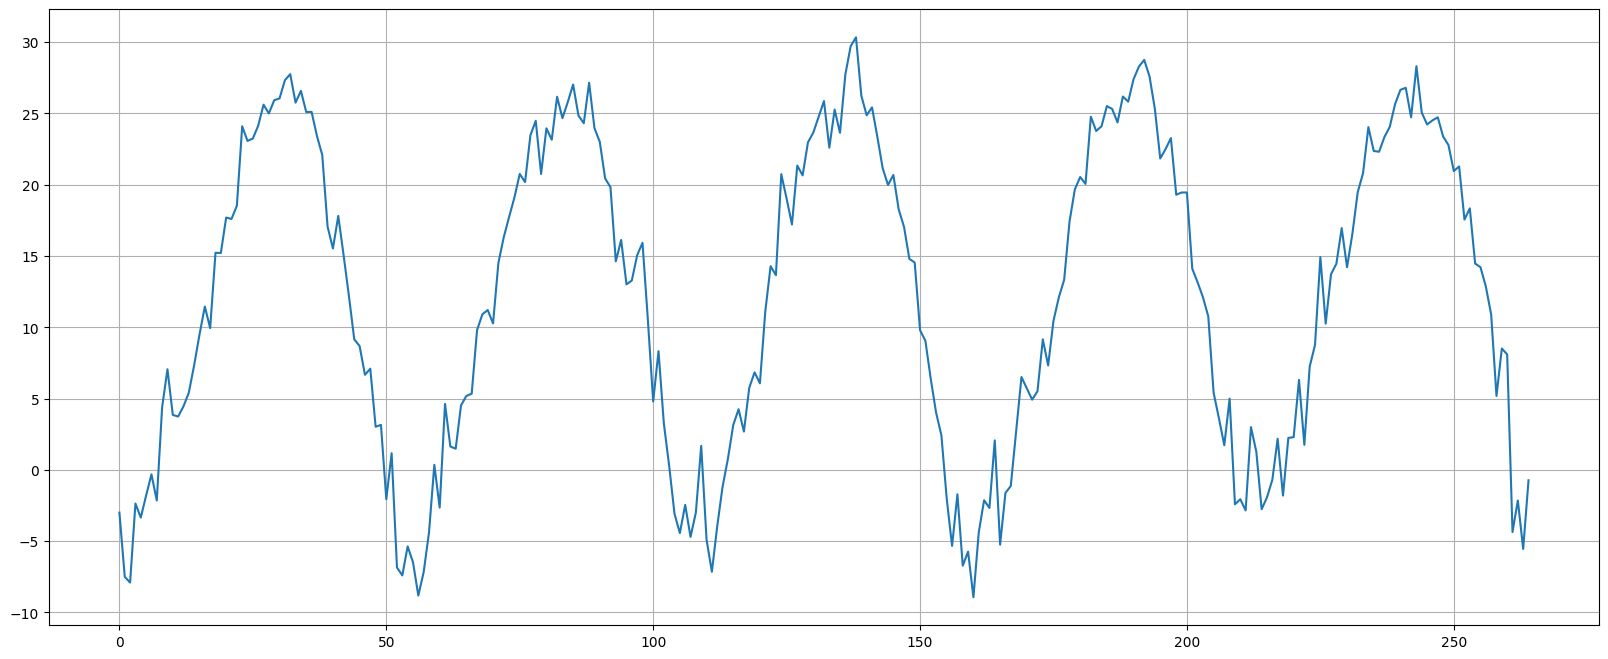

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data.AvgTemp)
plt.grid()
plt.show()

## 3.데이터 준비

### (1) y 만들기

In [ ]:
# 다음주 온도를 예측하고 싶다? shift로 한칸씩 땡겨올리기!(-1)/ 밀어내기(+1)

In [6]:
data['y'] = data['AvgTemp'].shift(-1)
data.dropna(axis = 0, inplace = True)
data.head()

,year,week,AvgTemp,y
0,2010,1,-3.000000,-7.500000
1,2010,2,-7.500000,-7.900000
2,2010,3,-7.900000,-2.357143
3,2010,4,-2.357143,-3.342857
4,2010,5,-3.342857,-1.800000


### (2) x, y 분리

In [7]:
x = data.loc[:, ['AvgTemp']]
y = data.loc[:,'y']

### (3) 스케일링

In [ ]:
#3차원 데이터셋 나누기 전에 먼저 스케일링 진행

In [8]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [9]:
x.shape, y.shape

((264, 1), (264,))

### (4) 3차원 구조 만들기

In [10]:
x2, y2 = temporalize(x, y, 4)
x2.shape, y2.shape

((261, 4, 1), (261,))

In [11]:
x2[:2]

array([[[0.15106693],
        [0.0364937 ],
        [0.02630941],
        [0.16743453]],

       [[0.0364937 ],
        [0.02630941],
        [0.16743453],
        [0.14233754]]])

In [12]:
y[:7], y2[:2]

(0   -7.500000
 1   -7.900000
 2   -2.357143
 3   -3.342857
 4   -1.800000
 5   -0.314286
 6   -2.142857
 Name: y, dtype: float64,
 array([-3.34285714, -1.8       ]))

### (5) 데이터 분할

* shuffle = False : 섞지 마라.(랜덤 분할 하지 마라)
* test_size= 53 :
    * 소수 : 비율
    * 자연수 : 개수

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

In [14]:
x_train.shape, y_train.shape

((208, 4, 1), (208,))

In [15]:
x_val.shape, y_val.shape

((53, 4, 1), (53,))

## 4.RNN : 무작정 모델링

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [16]:
x_train.shape

(208, 4, 1)

In [17]:
timesteps = x_train.shape[1] # 4
nfeatures = x_train.shape[2] # 1

### (2) 모델 구조 설계
* 다음 구조를 그대로 설계해 봅시다.
    * SimpleRNN(8, input_shape = (timesteps, nfeatures))
    * Dense(1)

In [18]:
clear_session()

model = Sequential([Input(shape = (timesteps, nfeatures)),
                    SimpleRNN(8),
                    Dense(1)])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 8)                   │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89 (356.00 B)

 Trainable params: 89 (356.00 B)

 Non-trainable params: 0 (0.00 B)

### (3) 컴파일 및 학습
* 다음 조건으로 학습해 봅시다.
    * epochs = 100
    * learning_rate = 0.01

In [19]:
model.compile(optimizer = Adam(learning_rate=0.01), loss = 'mse')
hist = model.fit(x_train, y_train, epochs = 100, verbose = 0, validation_split = .2).history

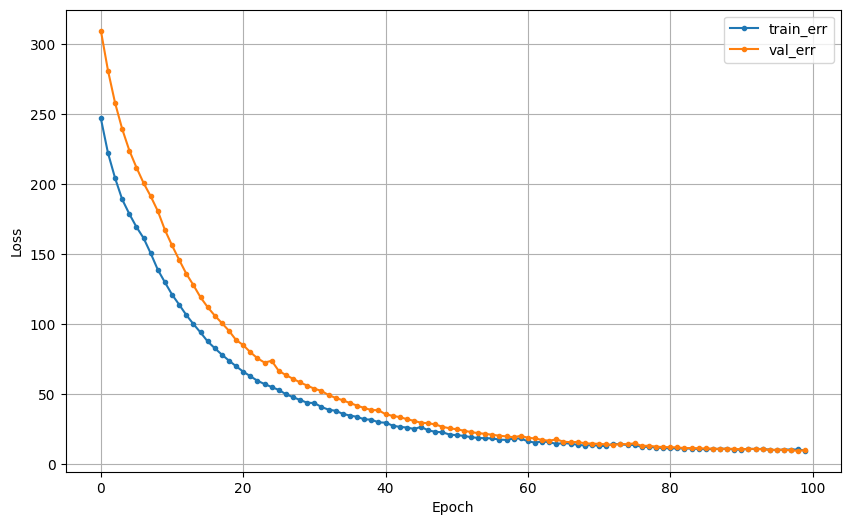

In [20]:
# 학습 곡선을 그려봅시다.
dl_history_plot(hist)

### (4) 예측 및 평가

In [21]:
# 예측
pred = model.predict(x_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [22]:
# 평가
mean_absolute_error(y_val, pred)

2.93811693981159

In [ ]:
# 여기서 mae=2.93이 무슨 뜻?
#-> 다음주 주간 온도를 예측하는데 이 모델은 평균적으로 2.93 도 정도로 오차가 나는 모델이야

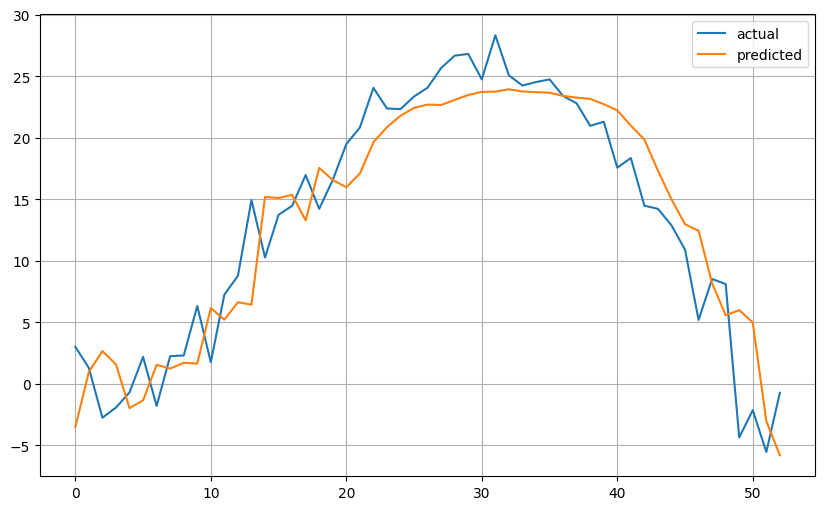

In [23]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 파란색이 실제이고 주황색이 우리 모델이 예측한 것

## 5.RNN 모델링②

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [38]:
timesteps = x_train.shape[1] # 4
nfeatures = x_train.shape[2] # 1
x_train.shape

(198, 14, 1)

### (2) 모델 구조 설계
* 이제 RNN 레이어를 추가해 봅시다.
    * SimpleRNN(8, input_shape = (timestep, nfeatures), return_sequences = True)
    * SimpleRNN(8)
    * Dense(1)

In [ ]:
timesteps, nfeatures

In [27]:
clear_session()

model = Sequential([Input(shape=(timesteps,nfeatures)),
                    SimpleRNN(8,return_sequences = True),
                    SimpleRNN(8),
                    Dense(1)])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 4, 8)                │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

### (3) 컴파일 및 학습
* 다음 조건으로 학습해 봅시다.
    * epochs = 200
    * learning_rate = 0.01

In [28]:
model.compile(optimizer = Adam(learning_rate=0.01), loss = 'mse')
hist = model.fit(x_train, y_train, epochs = 200, verbose = 0, validation_split = .2).history

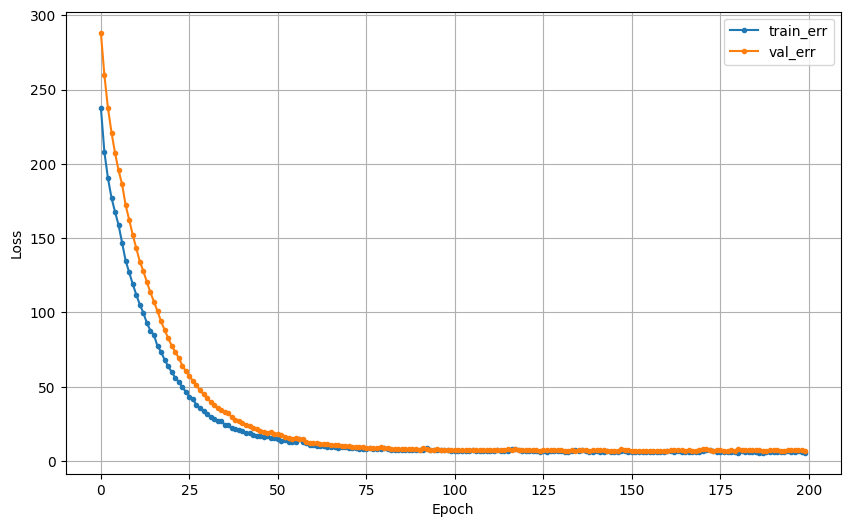

In [29]:
# 학습 곡선을 그려봅시다.
dl_history_plot(hist)

### (4) 예측 및 평가

In [30]:
# 예측
pred = model.predict(x_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step


In [31]:
# 평가
mean_absolute_error(y_val, pred)

2.4462637116332497

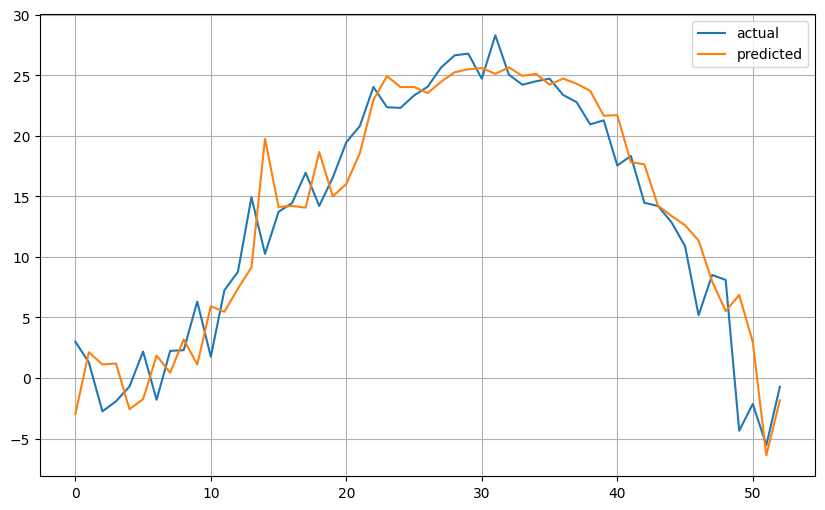

In [32]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 6.LSTM 모델링

### (1) 데이터 준비

* timestep

In [33]:
timesteps = 14
x2, y2 = temporalize(x, y, timesteps)
x2.shape, y2.shape

((251, 14, 1), (251,))

* 데이터 분할

In [34]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [35]:
x_train.shape

timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

### (3) 모델 구조 설계
* 5번 모델의 SimpleRNN을 LSTM 로 이름만 바꿔봅시다.

In [36]:
clear_session()

model = Sequential([LSTM(8, input_shape = (timesteps, nfeatures),return_sequences = True),
                    LSTM(8),
                    Dense(1)])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 14, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 873 (3.41 KB)

 Trainable params: 873 (3.41 KB)

 Non-trainable params: 0 (0.00 B)

### (4) 컴파일 및 학습

In [37]:
model.compile(optimizer = Adam(learning_rate=0.01), loss = 'mse')
hist = model.fit(x_train, y_train, epochs = 200, verbose = 0, validation_split = .2).history

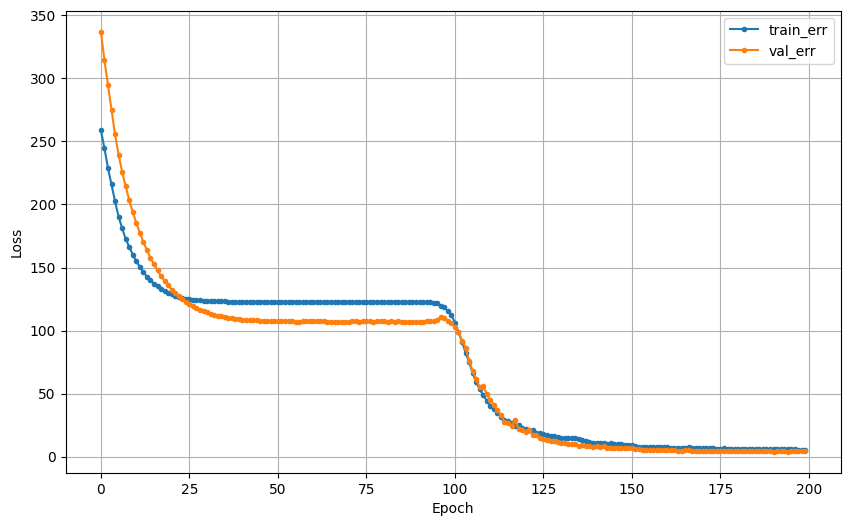

In [39]:
# 학습 곡선을 그려봅시다.
dl_history_plot(hist)

### (5) 예측 및 평가

In [40]:
# 예측
pred = model.predict(x_val)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step


In [41]:
# 평가
mean_absolute_error(y_val, pred)

1.894553104509775

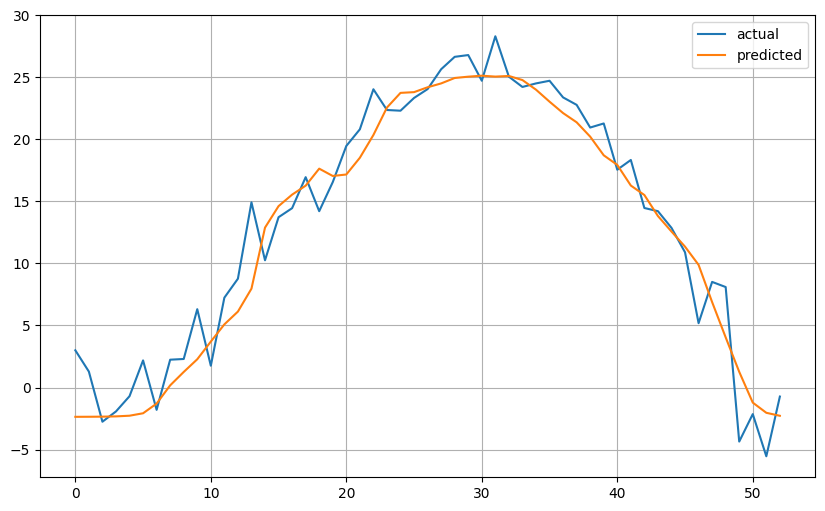

In [42]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 7.자유롭게 모델링~!
* 다음 항목을 조정하며 모델링을 수행해 봅시다.
    * timestep
    * 레이어와 노드수
    * learning_rate, epochs


### (1) 데이터 준비

* timestep

In [54]:
x_train.shape

(202, 10, 1)

In [55]:
timesteps = 10    # ⬅️ 값 입력
x2, y2 = temporalize(x, y, timesteps)
x2.shape, y2.shape

((255, 10, 1), (255,))

* 데이터 분할

In [56]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [57]:
timesteps=x_train.shape[1]
n=x_train.shape[2]

### (3) 모델 구조 설계


In [65]:
clear_session()

model=Sequential([Input(shape=(timesteps,n)),
                  LSTM(20, return_sequences=True),
                  LSTM(10, return_sequences=True),
                  Flatten(),
                  Dense(20,activation='relu'),
                  Dense(10,activation='relu'),
                  Dense(1)])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 20)              │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 10)              │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           2,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,241 (20.47 KB)

 Trainable params: 5,241 (20.47 KB)

 Non-trainable params: 0 (0.00 B)

### (4) 컴파일 및 학습

In [66]:
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

In [67]:
hist=model.fit(x_train,y_train,epochs=200,verbose=0,validation_split=0.2).history

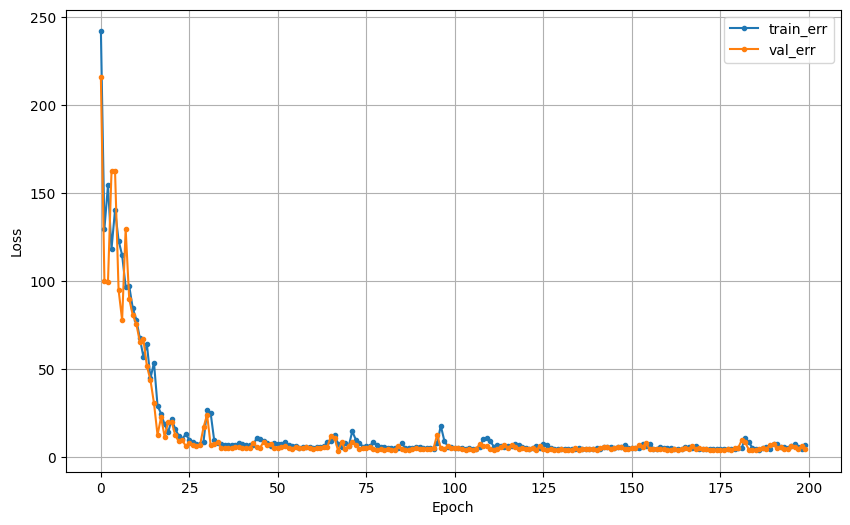

In [68]:
dl_history_plot(hist)

### (5) 예측 및 평가

In [69]:
pred=model.predict(x_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step


In [70]:
mean_absolute_error(y_val,pred)

1.9764835909914906

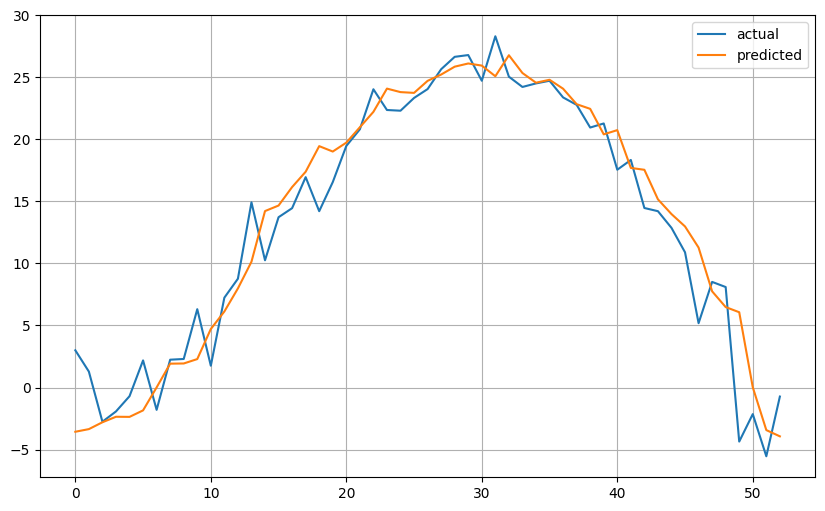

In [71]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()